# **SERS Classification_20211006_DNN**
# Dataset: 
*E. coli* BW25113 10^8 CFU/ml - Ampicillin [0/64] ng/ml treat 30min

400 datapoint for each



# Mounting your gdrive (Optional)
By mounting your gdrive, you can save and manage your data and models in your Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os

# your workspace in your drive
workspace = 'YOUR_WORKSPACE'


try:
  os.chdir(os.path.join('/content/gdrive/My Drive/', workspace))
except:
  os.mkdir(os.path.join('/content/gdrive/My Drive/', workspace))
  os.chdir(os.path.join('/content/gdrive/My Drive/', workspace))

Mounted at /content/gdrive


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Import Packages


In [ ]:
import numpy as np
import random
import torch

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import torchvision.transforms as transforms

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models

from torch.optim import Adam, AdamW

from sklearn.cluster import MiniBatchKMeans
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from scipy.cluster.vq import vq, kmeans

# from qqdm import qqdm, format_str
import pandas as pd

import pdb  # use pdb.set_trace() to set breakpoints for debugging

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


## Download Data
Download data from google drive, then unzip it.

You should have `/content/gdrive/My Drive/YOUR_WORKPLACE/SERSdata.csv`after running this block.<br><br>

**notes: if the google drive link is dead, you can download the data directly from Kaggle and upload it to the workspace**




In [ ]:
!gdown --id '1dbtiZeod41smPPdPPmN001XLstECDDaj' --output SERSdata.csv
# !unzip data.zip
# !ls 

Downloading...
From: https://drive.google.com/uc?id=1dbtiZeod41smPPdPPmN001XLstECDDaj
To: /content/gdrive/My Drive/YOUR_WORKSPACE/SERSdata.csv
100% 41.6M/41.6M [00:00<00:00, 101MB/s] 


## Preparing Data
Load the data file, then extract features and labels.

In [ ]:
SERS_RAWdata = pd.read_csv('/content/gdrive/My Drive/YOUR_WORKSPACE/SERSdata.csv')

In [ ]:
print('Sample Size: {}'.format(len(SERS_RAWdata)))
print('Feature Dimension: {}'.format(SERS_RAWdata.shape[1]))
# print('Sample Size: {}'.format(len(SERS_data)))


SERS_data = SERS_RAWdata[SERS_RAWdata.columns[1:]].to_numpy()
# print(SERS_data.shape[1])

label_dict = {'Amp64_30min': 1, 'Amp0_30min': 0, 'Nothing': '2'}
SERS_label = np.vectorize(label_dict.get)(SERS_RAWdata[SERS_RAWdata.columns[0]].to_numpy())
# print(SERS_RAWdata[SERS_RAWdata.columns[0]].to_numpy())
# print(SERS_label)



Sample Size: 800
Feature Dimension: 6646
6645
['Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min'
 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min'
 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min'
 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min'
 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min'
 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min'
 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min'
 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min'
 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min'
 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min'
 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min'
 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min'
 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min' 'Amp64_30min'
 'Amp64_30min' 'Amp64_30min' 'A

## Create Dataset

In [ ]:
import torch
from torch.utils.data import Dataset

class SERSDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = torch.from_numpy(X).float()
        if y is not None:
            y = y.astype(np.int)
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)


Split the labeled data into a training set and a validation set, you can modify the variable `VAL_RATIO` to change the ratio of validation data.

In [ ]:
TEST_RATIO = 0.2
VAL_RATIO = 0.2


# For Train-Val-Test dataset, We need to do model_selection.train_test_split TWICE
#    X_build --> X_train + X_val
# To have Complete Randomize: Set random_state=0
X_build, X_test, Y_build, Y_test = model_selection.train_test_split (SERS_data, SERS_label, test_size=TEST_RATIO, random_state=0)
X_train, X_val, Y_train, Y_val = model_selection.train_test_split (X_build, Y_build, test_size=0.25, random_state=0)


## FOR CHECKING
# X_train, X_val, Y_train, Y_val = model_selection.train_test_split (SERS_data, SERS_label, test_size=0.4, random_state=0)

# print(X_train.shape[0])
# print(X_train.shape[1])
# print(Y_train.shape[0])


# print(Y_train)
# print(X_train[0,:])

Create a data loader from the dataset, feel free to tweak the variable `BATCH_SIZE` here.

In [ ]:
BATCH_SIZE = 4

from torch.utils.data import DataLoader

train_set = SERSDataset(X_train, Y_train)
val_set = SERSDataset(X_val, Y_val)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) #only shuffle the training data
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

Cleanup the unneeded variables to save memory.<br>

**notes: if you need to use these variables later, then you may remove this block or clean up unneeded variables later<br>the data size is quite huge, so be aware of memory usage in colab**

In [ ]:
# import gc

# del train, train_label, train_x, train_y, val_x, val_y
# gc.collect()

## Create Model

Define model architecture, you are encouraged to change and experiment with the model architecture.

In [ ]:
import torch
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.layer1 = nn.Linear(6645, 1024)
        self.layer2 = nn.Linear(1024, 256)
        self.layer3 = nn.Linear(256, 32)
        self.out = nn.Linear(32, 2) 

        # self.act_fn = nn.Sigmoid()
        self.act_fn = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

        # self.net = nn.Sequential(
        #     nn.Linear(6645, 1024),
        #     nn.ReLU(),
        #     # nn.BatchNorm1d(num_features=1024),
        #     nn.Linear(6645, 256),
        #     nn.ReLU(),
        #     # nn.BatchNorm1d(num_features=256),
        #     nn.Linear(256, 32),
        #     nn.ReLU(),
        #     # nn.BatchNorm1d(num_features=32),
        #     nn.Linear(32, 2),
        # )



    def forward(self, x):
        x = self.layer1(x)
        # x = self.dropout(x)
        x = self.act_fn(x)

        x = self.layer2(x)
        # x = self.dropout(x)
        x = self.act_fn(x)

        x = self.layer3(x)
        # x = self.dropout(x)
        x = self.act_fn(x)

        x = self.out(x)
        
        # x = self.net(x)
        return x

In [ ]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(Classifier, self).__init__()
#         self.layer1 = nn.Linear(6645, 1024)
#         self.layer2 = nn.Linear(1024, 256)
#         self.layer3 = nn.Linear(256, 32)
#         self.out = nn.Linear(32, 2) 

#         # self.act_fn = nn.Sigmoid()
        
#         self.act_fn = nn.ReLU()

#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.act_fn(x)

#         x = self.layer2(x)
#         x = self.act_fn(x)

#         x = self.layer3(x)
#         x = self.act_fn(x)

#         x = self.out(x)
        
#         return x

## Training

In [ ]:
#check device
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'

Fix random seeds for reproducibility.

In [ ]:
# fix random seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Feel free to change the training parameters here.

In [ ]:
# fix random seed for reproducibility
same_seeds(0)

# get device 
device = get_device()
print(f'DEVICE: {device}')

# training parameters
num_epoch = 50               # number of training epoch
learning_rate = 5e-5      # learning rate
# weight_decay

# the path where checkpoint saved
model_path = './model.ckpt'

# create model, define a loss function, and optimizer
model = Classifier().to(device)

# # Alternation: CNN model
# model = CNN().to(device)

criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

DEVICE: cuda


In [ ]:
# start training

best_acc = 0.0
for epoch in range(num_epoch):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    # training
    model.train() # set the model to training mode

    # for i, data in enumerate(train_loader):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() 
        outputs = model(inputs) 
        batch_loss = criterion(outputs, labels)
        _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        batch_loss.backward() 
        optimizer.step() 

        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += batch_loss.item()

    # validation
    if len(val_set) > 0:
        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels) 
                _, val_pred = torch.max(outputs, 1) 
            
                val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
                val_loss += batch_loss.item()

            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
                epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader), val_acc/len(val_set), val_loss/len(val_loader)
            ))

            # if the model improves, save a checkpoint at this epoch
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print('saving model with acc {:.3f}'.format(best_acc/len(val_set)))
    else:
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader)
        ))

# if not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print('saving model at last epoch')


[001/050] Train Acc: 0.604167 Loss: 5.063988 | Val Acc: 0.500000 loss: 3.459043
saving model with acc 0.500
[002/050] Train Acc: 0.772917 Loss: 1.108791 | Val Acc: 0.787500 loss: 0.683361
saving model with acc 0.787
[003/050] Train Acc: 0.772917 Loss: 0.917878 | Val Acc: 0.862500 loss: 0.423397
saving model with acc 0.863
[004/050] Train Acc: 0.795833 Loss: 1.506416 | Val Acc: 0.825000 loss: 0.483952
[005/050] Train Acc: 0.839583 Loss: 0.762257 | Val Acc: 0.681250 loss: 1.533788
[006/050] Train Acc: 0.835417 Loss: 0.749228 | Val Acc: 0.800000 loss: 0.757075
[007/050] Train Acc: 0.893750 Loss: 0.500716 | Val Acc: 0.781250 loss: 0.754439
[008/050] Train Acc: 0.866667 Loss: 0.551291 | Val Acc: 0.900000 loss: 0.319683
saving model with acc 0.900
[009/050] Train Acc: 0.922917 Loss: 0.371597 | Val Acc: 0.743750 loss: 1.063555
[010/050] Train Acc: 0.956250 Loss: 0.160503 | Val Acc: 0.618750 loss: 2.393599
[011/050] Train Acc: 0.841667 Loss: 0.711769 | Val Acc: 0.818750 loss: 0.739798
[012/050

## Testing

Create a testing dataset, and load model from the saved checkpoint.

In [ ]:
# create testing dataset
test_set = SERSDataset(X_test, Y_test)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# create model and load weights from checkpoint
model = Classifier().to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## Make prediction.

Also create confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

y_predict = []
y_true = []
y_score = []


test_acc = 0.0
test_loss = 0.0


model.eval() # set the model to evaluation mode

with torch.no_grad():
  for i, data in enumerate(test_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    batch_loss = criterion(outputs, labels) 
    _, test_pred = torch.max(outputs, 1) 

    score = []
    for j in range(outputs.shape[0]):
      label_idx = labels[j].item()
      score.append(outputs[j][label_idx].item())
      # print(label_idx)
      # print(outputs)
      # print(outputs[0][1])
      # print(j)

            
    test_acc += (test_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
    test_loss += batch_loss.item()

    y_predict.extend(test_pred.tolist())
    y_true.extend(labels.tolist())
    y_score.extend(score)

print('Test Acc: {:3.6f} loss: {:3.6f}'.format(
    test_acc/len(test_set), test_loss/len(test_loader)
    ))
  
# print(y_predict) 
# print(y_true)  
# print(y_score) 

conf = confusion_matrix(y_true, y_predict)
print(conf)

Test Acc: 0.887500 loss: 0.275739
[[77 11]
 [ 7 65]]


## ROC Curve & AUC


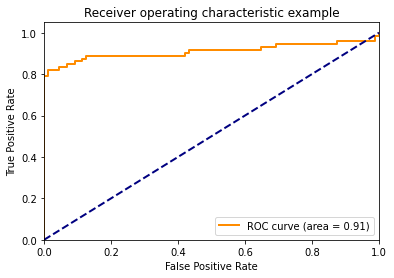

In [ ]:
# import numpy as np
# from sklearn.metrics import roc_curve, auc
# y = np.array([0, 0, 1, 1])
# scores = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt

fig = plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
#fig.savefig('/tmp/roc.png')
plt.show()




Write prediction to a CSV file.

After finish running this block, download the file `prediction.csv` from the files section on the left-hand side and submit it to Kaggle.

In [ ]:
# with open('prediction.csv', 'w') as f:
#     f.write('Id,Class\n')
#     for i, y in enumerate(predict):
#         f.write('{},{}\n'.format(i, y))